## Data Preprocessing - 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK resources (run once)
# nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration parameters
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 100

print(f"Parameters set:")
print(f"Max words: {MAX_WORDS}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Parameters set:
Max words: 20000
Max sequence length: 60
Embedding dimension: 100


In [3]:
# File paths
TRAIN_PATH = "liar_dataset/train.tsv"
VAL_PATH = "liar_dataset/valid.tsv"
TEST_PATH = "liar_dataset/test.tsv"
GLOVE_PATH = "glove.6B.100d.txt"

# Load the dataset from TSV files
print("Loading data...")
train_df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)
val_df = pd.read_csv(VAL_PATH, sep='\t', header=None)
test_df = pd.read_csv(TEST_PATH, sep='\t', header=None)

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

Loading data...
Train shape: (10240, 14)
Validation shape: (1284, 14)
Test shape: (1267, 14)


In [4]:
def replace_labels(label):
    """Convert multi-class labels to binary classification"""
    label = label.lower().replace(" ", "-")
    return "true" if label in ["true", "mostly-true"] else "false"

In [5]:
# Apply label transformation to all dataframes
print("Applying label transformation...")
train_df[1] = train_df[1].apply(replace_labels)
val_df[1] = val_df[1].apply(replace_labels)
test_df[1] = test_df[1].apply(replace_labels)

# Print class distribution
print("Train Set Label Distribution:")
print(train_df[1].value_counts())
print(f"Train set total: {len(train_df)}")

print("\nValidation Set Label Distribution:")
print(val_df[1].value_counts())
print(f"Validation set total: {len(val_df)}")

print("\nTest Set Label Distribution:")
print(test_df[1].value_counts())
print(f"Test set total: {len(test_df)}")

Applying label transformation...
Train Set Label Distribution:
1
false    6602
true     3638
Name: count, dtype: int64
Train set total: 10240

Validation Set Label Distribution:
1
false    864
true     420
Name: count, dtype: int64
Validation set total: 1284

Test Set Label Distribution:
1
false    818
true     449
Name: count, dtype: int64
Test set total: 1267


In [6]:
def combine_text(df):
    """Concatenate statement with relevant metadata fields"""
    df = df.fillna('')
    combined = (
        df[2].astype(str) + " " +  # statement
        df[3].astype(str) + " " +  # subject(s)
        df[4].astype(str) + " " +  # speaker
        df[5].astype(str) + " " +  # speaker's job title
        df[6].astype(str) + " " +  # state info
        df[7].astype(str) + " " +  # party affiliation
        df[13].astype(str)         # context (venue/location)
    )
    return combined.tolist()

In [7]:
def preprocess_text(text):
    """Preprocess individual text"""
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [8]:
# Create combined text inputs for all datasets
print("Creating combined text inputs...")
train_statements = combine_text(train_df)
val_statements = combine_text(val_df)
test_statements = combine_text(test_df)

print(f"Combined {len(train_statements)} training statements")
print(f"Combined {len(val_statements)} validation statements")
print(f"Combined {len(test_statements)} test statements")

# Apply preprocessing to all statements
print("Preprocessing text...")
train_statements_processed = [preprocess_text(statement) for statement in tqdm(train_statements, desc="Training Statements")]
val_statements_processed = [preprocess_text(statement) for statement in tqdm(val_statements, desc="Validation Statements")]
test_statements_processed = [preprocess_text(statement) for statement in tqdm(test_statements, desc="Test Statements")]

Creating combined text inputs...
Combined 10240 training statements
Combined 1284 validation statements
Combined 1267 test statements
Preprocessing text...


Test Statements: 100%|████████████████████| 1267/1267 [00:00<00:00, 2475.30it/s]


In [9]:
def map_labels(label_list):
    """Map string labels to integers"""
    label_map = {"false": 0, "true": 1}
    mapped = []
    for label in label_list:
        label = label.lower().replace(" ", "-")
        mapped.append(label_map.get(label, 0))
    return np.array(mapped)

# Prepare labels
print("Preparing labels...")
train_labels = map_labels(train_df[1].tolist())
val_labels = map_labels(val_df[1].tolist())
test_labels = map_labels(test_df[1].tolist())

# Show label distribution
print(f"\nTrain label distribution: {np.bincount(train_labels)}")
print(f"Validation label distribution: {np.bincount(val_labels)}")
print(f"Test label distribution: {np.bincount(test_labels)}")

Preparing labels...

Train label distribution: [6602 3638]
Validation label distribution: [864 420]
Test label distribution: [818 449]


In [10]:
# Initialize tokenizer
print("Setting up tokenizer...")
tokenizer = Tokenizer(num_words=MAX_WORDS)

# Fit tokenizer on all preprocessed statements
all_statements = train_statements_processed + val_statements_processed + test_statements_processed
tokenizer.fit_on_texts(all_statements)

print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)}")
print(f"Max words used: {MAX_WORDS}")

Setting up tokenizer...
Tokenizer vocabulary size: 14785
Max words used: 20000


Converting statements to sequences...


Test Sequences: 100%|████████████████████| 1267/1267 [00:00<00:00, 60276.11it/s]


Sequence conversion completed!

Sequence length statistics:
  Mean length: 23.66
  Max length: 433
  Min length: 9
  95th percentile: 34.00


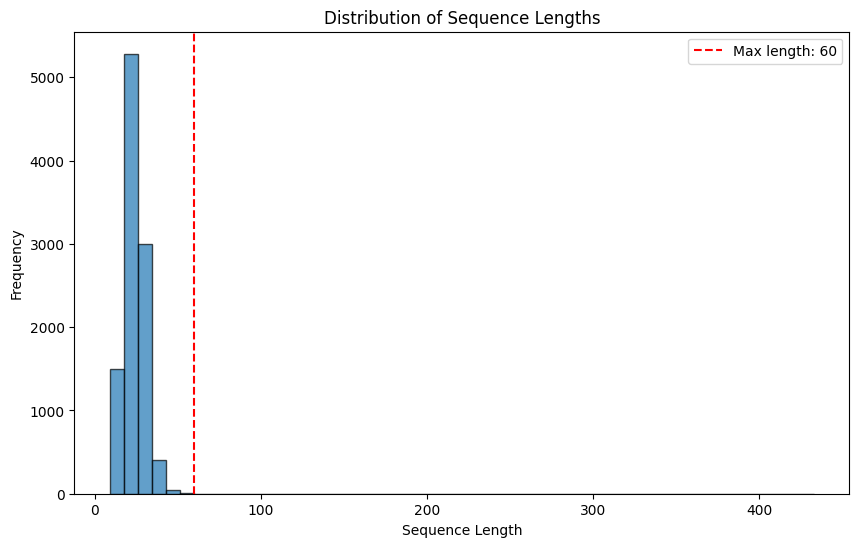

In [11]:
# Convert statements to sequences
print("Converting statements to sequences...")
train_sequences = [tokenizer.texts_to_sequences([text])[0] for text in tqdm(train_statements_processed, desc="Training Sequences")]
val_sequences = [tokenizer.texts_to_sequences([text])[0] for text in tqdm(val_statements_processed, desc="Validation Sequences")]
test_sequences = [tokenizer.texts_to_sequences([text])[0] for text in tqdm(test_statements_processed, desc="Test Sequences")]

print("Sequence conversion completed!")

# Show sequence statistics
train_lengths = [len(seq) for seq in train_sequences]
print(f"\nSequence length statistics:")
print(f"  Mean length: {np.mean(train_lengths):.2f}")
print(f"  Max length: {np.max(train_lengths)}")
print(f"  Min length: {np.min(train_lengths)}")
print(f"  95th percentile: {np.percentile(train_lengths, 95):.2f}")

# Plot sequence length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', linestyle='--', label=f'Max length: {MAX_SEQUENCE_LENGTH}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

In [12]:
# Pad sequences to the same length
print("Padding sequences...")
train_data_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
val_data_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
test_data_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

print(f"Padded data shapes:")
print(f"  Training: {train_data_padded.shape}")
print(f"  Validation: {val_data_padded.shape}")
print(f"  Test: {test_data_padded.shape}")

# Show sample padded sequence
print(f"\nSample padded sequence (first 20 elements):")
print(train_data_padded[0][:20])

Padding sequences...
Padded data shapes:
  Training: (10240, 60)
  Validation: (1284, 60)
  Test: (1267, 60)

Sample padded sequence (first 20 elements):
[   4 6466  895  211  249  206  457 6467  100 1956  100 6468 8547    2
   34   15    1  376    0    0]


In [13]:
# Load GloVe embeddings
print("Loading GloVe embeddings...")
embeddings_index = {}

try:
    with open(GLOVE_PATH, encoding='utf8') as f:
        # Count total lines for progress bar
        total_lines = sum(1 for _ in open(GLOVE_PATH, encoding='utf8'))
        print(f"Total GloVe vectors: {total_lines}")
        
        # Read embeddings
        for line in tqdm(f, total=total_lines, desc="Reading GloVe File"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print(f"Loaded {len(embeddings_index)} word vectors")
    
except FileNotFoundError:
    print(f"GloVe file not found at {GLOVE_PATH}")
    print("You can download it from: https://nlp.stanford.edu/projects/glove/")
    # Create random embeddings as fallback
    print("Creating random embeddings as fallback...")
    embeddings_index = {}

Loading GloVe embeddings...
Total GloVe vectors: 400000


Reading GloVe File: 100%|████████████| 400000/400000 [00:07<00:00, 57128.80it/s]

Loaded 400000 word vectors


In [14]:
# Create embedding matrix
print("Creating embedding matrix...")
word_index = tokenizer.word_index
num_words = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Fill embedding matrix
words_found = 0
words_not_found = 0

for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_found += 1
        else:
            words_not_found += 1

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Words found in GloVe: {words_found}")
print(f"Words not found in GloVe: {words_not_found}")
print(f"Coverage: {words_found / (words_found + words_not_found) * 100:.2f}%")

Creating embedding matrix...
Embedding matrix shape: (14786, 100)
Words found in GloVe: 13647
Words not found in GloVe: 1138
Coverage: 92.30%


=== DATA PROCESSING SUMMARY ===
Training samples: 10240
Validation samples: 1284
Test samples: 1267
Vocabulary size: 14786
Sequence length: 60
Embedding dimension: 100


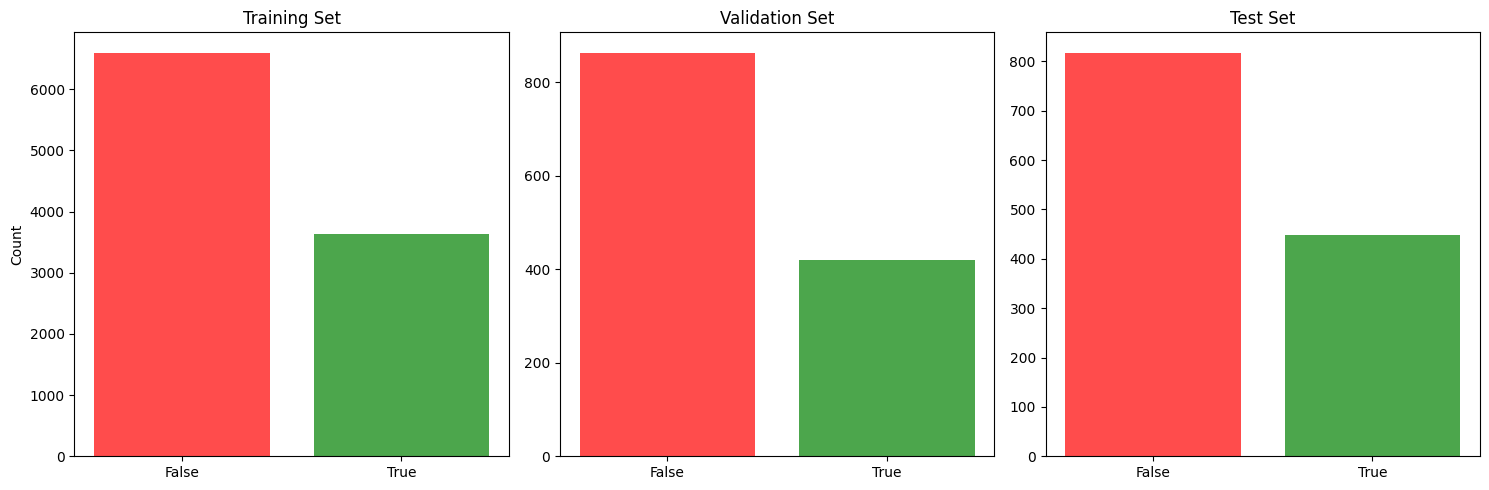

Train set - False: 64.5%, True: 35.5%
Val set - False: 67.3%, True: 32.7%
Test set - False: 64.6%, True: 35.4%


In [15]:
# Create summary of processed data
print("=== DATA PROCESSING SUMMARY ===")
print(f"Training samples: {len(train_data_padded)}")
print(f"Validation samples: {len(val_data_padded)}")
print(f"Test samples: {len(test_data_padded)}")
print(f"Vocabulary size: {num_words}")
print(f"Sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training set
train_counts = np.bincount(train_labels)
axes[0].bar(['False', 'True'], train_counts, color=['red', 'green'], alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_ylabel('Count')

# Validation set
val_counts = np.bincount(val_labels)
axes[1].bar(['False', 'True'], val_counts, color=['red', 'green'], alpha=0.7)
axes[1].set_title('Validation Set')

# Test set
test_counts = np.bincount(test_labels)
axes[2].bar(['False', 'True'], test_counts, color=['red', 'green'], alpha=0.7)
axes[2].set_title('Test Set')

plt.tight_layout()
plt.show()

# Print class balance
for name, labels in [('Train', train_labels), ('Val', val_labels), ('Test', test_labels)]:
    false_pct = (labels == 0).mean() * 100
    true_pct = (labels == 1).mean() * 100
    print(f"{name} set - False: {false_pct:.1f}%, True: {true_pct:.1f}%")

In [16]:
# Save all preprocessed data and objects
print("Saving preprocessed data...")

# Create data dictionary
preprocessed_data = {
    'train_data': train_data_padded,
    'val_data': val_data_padded,
    'test_data': test_data_padded,
    'train_labels': train_labels,
    'val_labels': val_labels,
    'test_labels': test_labels,
    'embedding_matrix': embedding_matrix,
    'num_words': num_words,
    'embedding_dim': EMBEDDING_DIM,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'tokenizer': tokenizer
}

# Save to pickle file
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessed data saved to 'preprocessed_data.pkl'")
print("✅ Data preprocessing completed successfully!")
print("You can now use this data to train your LSTM model.")

Saving preprocessed data...
Preprocessed data saved to 'preprocessed_data.pkl'
✅ Data preprocessing completed successfully!
You can now use this data to train your LSTM model.


## LSTM Model Training - 

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPool1D, Dropout, Bidirectional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully!")

TensorFlow version: 2.19.0
Libraries imported successfully!


In [18]:
# Model architecture parameters
LSTM_UNITS = 256
DENSE_UNITS_1 = 64
DENSE_UNITS_2 = 64
DROPOUT_RATE = 0.5
L2_REG = 0.01

# Training parameters
BATCH_SIZE = 256
EPOCHS = 10
CLASS_WEIGHT_DICT = {0: 1.0, 1: 1.6}

# Model save path
MODEL_SAVE_PATH = 'lstm_model.keras'

print("Model parameters set:")
print(f"LSTM units: {LSTM_UNITS}")
print(f"Dense layer 1 units: {DENSE_UNITS_1}")
print(f"Dense layer 2 units: {DENSE_UNITS_2}")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Class weights: {CLASS_WEIGHT_DICT}")

Model parameters set:
LSTM units: 256
Dense layer 1 units: 64
Dense layer 2 units: 64
Dropout rate: 0.5
Batch size: 256
Epochs: 10
Class weights: {0: 1.0, 1: 1.6}


In [19]:
# Use the preprocessed data from previous cells
# (No need to load from pickle since variables are already in memory)
train_data = train_data_padded
val_data = val_data_padded
test_data = test_data_padded
# train_labels, val_labels, test_labels are already available
# embedding_matrix, num_words are already available
embedding_dim = EMBEDDING_DIM
max_sequence_length = MAX_SEQUENCE_LENGTH

print("Data variables prepared:")
print(f"Train data shape: {train_data.shape}")
print(f"Val data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {num_words}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Max sequence length: {max_sequence_length}")

Data variables prepared:
Train data shape: (10240, 60)
Val data shape: (1284, 60)
Test data shape: (1267, 60)
Embedding matrix shape: (14786, 100)
Vocabulary size: 14786
Embedding dimension: 100
Max sequence length: 60


In [20]:
# Build LSTM model architecture
print("Building LSTM model...")

model = Sequential()
model.add(Embedding(num_words, embedding_dim, 
                   weights=[embedding_matrix], trainable=False, mask_zero=True))
model.add(LSTM(LSTM_UNITS, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(DENSE_UNITS_1, activation="tanh", kernel_regularizer=l2(L2_REG)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(DENSE_UNITS_2, activation="tanh", kernel_regularizer=l2(L2_REG)))
model.add(Dense(1, activation="sigmoid"))

# Build the model by specifying the input shape
model.build(input_shape=(None, max_sequence_length))

print("Model architecture built!")
print(f"Total parameters: {model.count_params():,}")

Building LSTM model...
Model architecture built!
Total parameters: 1,864,841


/opt/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [21]:
# Compile the model
print("Compiling model...")

model.compile(
    optimizer=Adam(learning_rate=0.0006),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

print("Model compiled successfully!")

# Display model summary
print("\nModel Summary:")
model.summary()

Compiling model...
Model compiled successfully!

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 60, 100)        │     1,478,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 256)        │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,864,841 (7.11 MB)

 Trainable params: 386,241 (1.47 MB)

 Non-trainable params: 1,478,600 (5.64 MB)

In [22]:
# Train the LSTM model
print("Training LSTM model...")

print(f"Class weights: {CLASS_WEIGHT_DICT}")


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Start training
lstm_history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHT_DICT,
    callbacks=[early_stopping, lr_scheduler]
)

print("Training completed!")

Training LSTM model...
Class weights: {0: 1.0, 1: 1.6}
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 348ms/step - accuracy: 0.5721 - auc: 0.5261 - loss: 2.3589 - precision: 0.3855 - recall: 0.3718 - val_accuracy: 0.5974 - val_auc: 0.6318 - val_loss: 1.8119 - val_precision: 0.4201 - val_recall: 0.6071 - learning_rate: 6.0000e-04
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 0.5928 - auc: 0.5871 - loss: 1.8658 - precision: 0.4407 - recall: 0.4805 - val_accuracy: 0.5693 - val_auc: 0.6411 - val_loss: 1.4554 - val_precision: 0.4051 - val_recall: 0.6762 - learning_rate: 6.0000e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step - accuracy: 0.6115 - auc: 0.6070 - loss: 1.5221 - precision: 0.4608 - recall: 0.4598 - val_accuracy: 0.6573 - val_auc: 0.6466 - val_loss: 1.1491 - val_precision: 0.4733 - val_recall: 0.4214 - learning_rate: 6.0000e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.6436 - auc: 0.6440 - loss: 1.2739 - precision: 0.4931 - recall: 0

In [23]:
# Evaluate the model on test set
print("Evaluating LSTM model on test set...")
test_metrics = model.evaluate(test_data, test_labels, return_dict=True)

# Print all metrics
print(f"\n=== FINAL TEST RESULTS ===")
print(f"LSTM Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"LSTM Test Precision: {test_metrics['precision']:.4f}")
print(f"LSTM Test Recall: {test_metrics['recall']:.4f}")
print(f"LSTM Test AUC: {test_metrics['auc']:.4f}")

# Calculate F1 score
precision = test_metrics['precision']
recall = test_metrics['recall']
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"LSTM Test F1 Score: {f1_score:.4f}")

Evaluating LSTM model on test set...
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6241 - auc: 0.6728 - loss: 0.6839 - precision: 0.4720 - recall: 0.6244

=== FINAL TEST RESULTS ===
LSTM Test Accuracy: 0.6204
LSTM Test Precision: 0.4732
LSTM Test Recall: 0.6303
LSTM Test AUC: 0.6657
LSTM Test F1 Score: 0.5406


In [24]:
# Make predictions on test data
print("Making predictions on test set...")
y_pred = model.predict(test_data, batch_size=BATCH_SIZE, verbose=0)

# Convert predictions to binary classes
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true_classes = test_labels

print(f"Predictions shape: {y_pred.shape}")
print(f"Binary predictions shape: {y_pred_classes.shape}")
print(f"True labels shape: {y_true_classes.shape}")

# Show sample predictions
print(f"\nSample predictions (first 10):")
for i in range(10):
    prob = y_pred[i][0]
    pred_class = y_pred_classes[i]
    true_class = y_true_classes[i]
    correct = "✓" if pred_class == true_class else "✗"
    print(f"Sample {i+1}: Prob={prob:.3f}, Pred={pred_class}, True={true_class} {correct}")

Making predictions on test set...
Predictions shape: (1267, 1)
Binary predictions shape: (1267,)
True labels shape: (1267,)

Sample predictions (first 10):
Sample 1: Prob=0.353, Pred=0, True=1 ✗
Sample 2: Prob=0.620, Pred=1, True=0 ✗
Sample 3: Prob=0.220, Pred=0, True=0 ✓
Sample 4: Prob=0.127, Pred=0, True=0 ✓
Sample 5: Prob=0.211, Pred=0, True=0 ✓
Sample 6: Prob=0.613, Pred=1, True=1 ✓
Sample 7: Prob=0.665, Pred=1, True=1 ✓
Sample 8: Prob=0.173, Pred=0, True=0 ✓
Sample 9: Prob=0.270, Pred=0, True=1 ✗
Sample 10: Prob=0.400, Pred=0, True=0 ✓


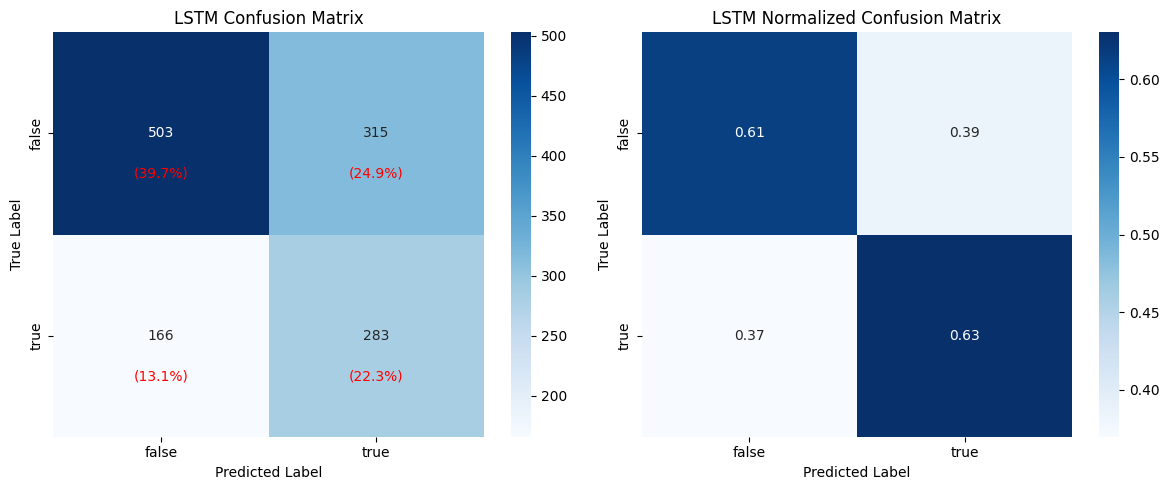

Confusion Matrix Statistics:
True Negatives: 503
False Positives: 315
False Negatives: 166
True Positives: 283


In [25]:
# Create and plot confusion matrix
class_names = ['false', 'true']
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create figure with subplots
plt.figure(figsize=(12, 5))

# Regular confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')

# Add text annotations with percentages
total = cm.sum()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Print confusion matrix statistics
print("Confusion Matrix Statistics:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

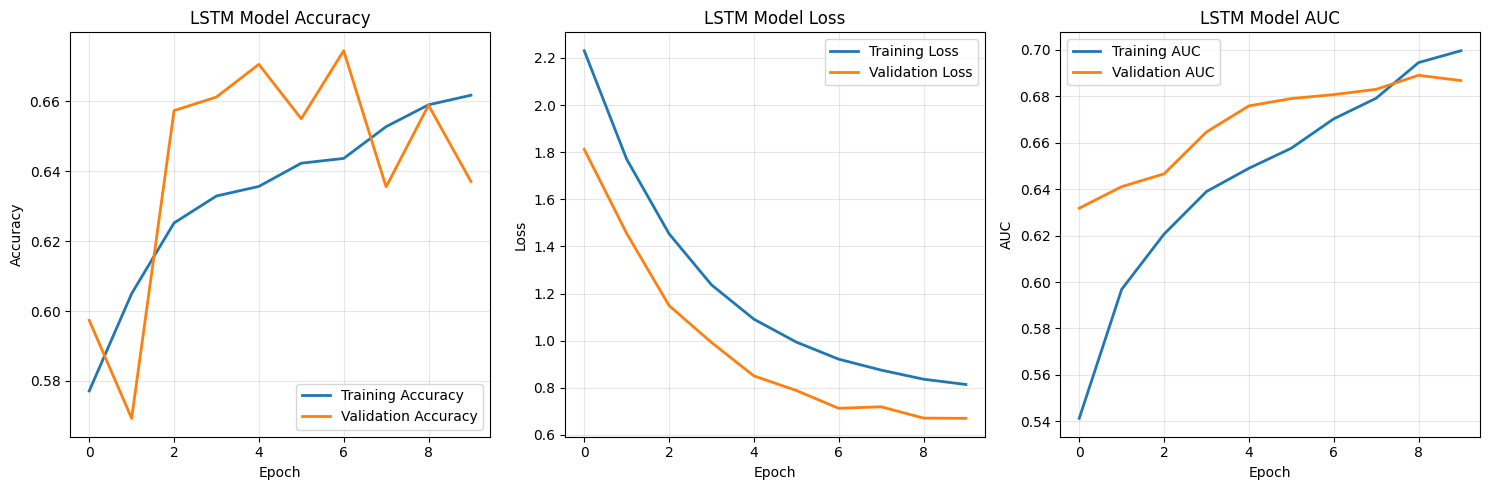


LSTM Best epoch: 7
LSTM Best validation accuracy: 0.6745
LSTM Training accuracy at best epoch: 0.6437


In [39]:
# Plot LSTM training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(lstm_history.history['auc'], label='Training AUC', linewidth=2)
plt.plot(lstm_history.history['val_auc'], label='Validation AUC', linewidth=2)
plt.title('LSTM Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best epoch information
lstm_best_epoch = np.argmax(lstm_history.history['val_accuracy'])
print(f"\nLSTM Best epoch: {lstm_best_epoch + 1}")
print(f"LSTM Best validation accuracy: {lstm_history.history['val_accuracy'][lstm_best_epoch]:.4f}")
print(f"LSTM Training accuracy at best epoch: {lstm_history.history['accuracy'][lstm_best_epoch]:.4f}")


=== DETAILED PERFORMANCE ANALYSIS ===

Classification Report:
              precision    recall  f1-score   support

       False     0.7519    0.6149    0.6765       818
        True     0.4732    0.6303    0.5406       449

    accuracy                         0.6204      1267
   macro avg     0.6126    0.6226    0.6086      1267
weighted avg     0.6531    0.6204    0.6284      1267



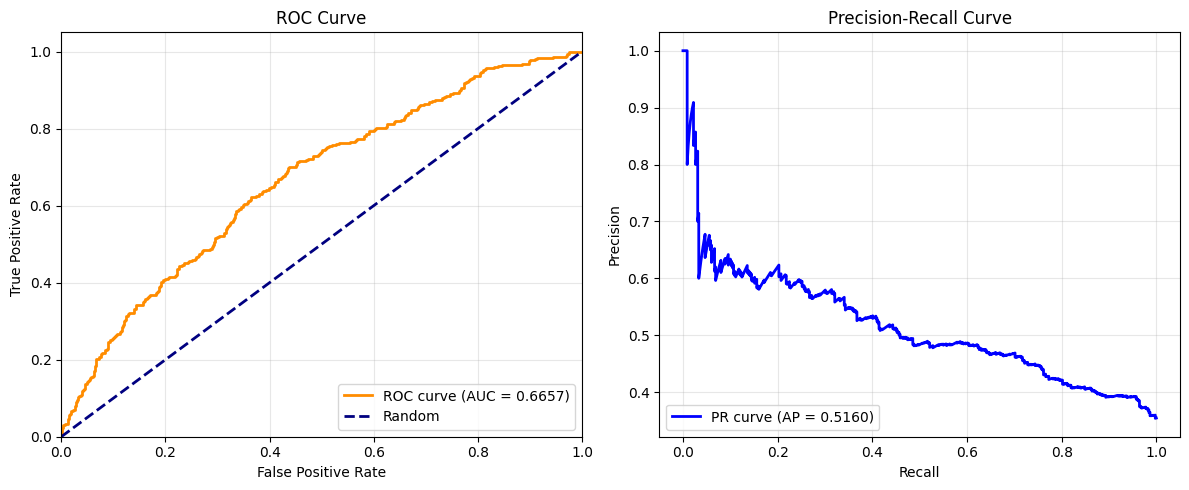

In [27]:
# Detailed performance analysis
print("=== DETAILED PERFORMANCE ANALYSIS ===")

# Per-class performance
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=['False', 'True'], digits=4))

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_vals, recall_vals, _ = precision_recall_curve(y_true_classes, y_pred.flatten())
avg_precision = average_precision_score(y_true_classes, y_pred.flatten())

plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='blue', lw=2, 
         label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# Analyze different prediction thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_results = []

print("Threshold Analysis:")
print("Threshold | Accuracy | Precision | Recall | F1-Score")
print("-" * 55)

for threshold in thresholds:
    pred_thresh = (y_pred > threshold).astype(int).flatten()
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    acc = accuracy_score(y_true_classes, pred_thresh)
    prec = precision_score(y_true_classes, pred_thresh, zero_division=0)
    rec = recall_score(y_true_classes, pred_thresh, zero_division=0)
    f1 = f1_score(y_true_classes, pred_thresh, zero_division=0)
    
    threshold_results.append([threshold, acc, prec, rec, f1])
    print(f"   {threshold:.1f}    |  {acc:.4f}  |  {prec:.4f}   |  {rec:.4f}  |  {f1:.4f}")

# Find best threshold based on F1 score
threshold_results = np.array(threshold_results)
best_threshold_idx = np.argmax(threshold_results[:, 4])  # F1 score column
best_threshold = threshold_results[best_threshold_idx, 0]
best_f1 = threshold_results[best_threshold_idx, 4]

# print(f"\nBest threshold: {best_threshold:.1f} (F1-Score: {best_f1:.4f})")

Threshold Analysis:
Threshold | Accuracy | Precision | Recall | F1-Score
-------------------------------------------------------
   0.1    |  0.3536  |  0.3539   |  0.9978  |  0.5224
   0.2    |  0.4112  |  0.3736   |  0.9777  |  0.5406
   0.3    |  0.4736  |  0.3931   |  0.8931  |  0.5459
   0.4    |  0.5525  |  0.4272   |  0.7706  |  0.5496
   0.5    |  0.6204  |  0.4732   |  0.6303  |  0.5406
   0.6    |  0.6511  |  0.5094   |  0.4209  |  0.4610
   0.7    |  0.6709  |  0.6067   |  0.2027  |  0.3038
   0.8    |  0.6511  |  0.8889   |  0.0178  |  0.0349
   0.9    |  0.6456  |  0.0000   |  0.0000  |  0.0000


In [29]:
# Save the trained model
print("Saving model...")
model.save(MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

# Save training history
with open('lstm_training_history.pkl', 'wb') as f:
    pickle.dump(lstm_history.history, f)
print("Training history saved to: lstm_training_history.pkl")

# Save predictions and results
results_dict = {
    'test_metrics': test_metrics,
    'y_pred': y_pred,
    'y_pred_classes': y_pred_classes,
    'y_true_classes': y_true_classes,
    'confusion_matrix': cm,
    'best_threshold': best_threshold,
    'threshold_results': threshold_results,
    'model_params': {
        'lstm_units': LSTM_UNITS,
        'dense_units_1': DENSE_UNITS_1,
        'dense_units_2': DENSE_UNITS_2,
        'dropout_rate': DROPOUT_RATE,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'class_weights': CLASS_WEIGHT_DICT
    }
}

with open('lstm_model_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("Model results saved to: lstm_model_results.pkl")

Saving model...
Model saved to: lstm_model.keras
Training history saved to: lstm_training_history.pkl
Model results saved to: lstm_model_results.pkl


In [30]:
# Display final summary
print("=" * 60)
print("             FINAL MODEL SUMMARY")
print("=" * 60)

print(f"Model Architecture:")
print(f"  - Embedding Layer: {num_words} words, {embedding_dim}D")
print(f"  - LSTM Layer: {LSTM_UNITS} units")
print(f"  - Dense Layers: {DENSE_UNITS_1} -> {DENSE_UNITS_2} -> 1")
print(f"  - Dropout Rate: {DROPOUT_RATE}")
print(f"  - Total Parameters: {model.count_params():,}")

print(f"\nTraining Configuration:")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Class Weights: {CLASS_WEIGHT_DICT}")

# Recalculate F1 score to avoid variable name conflict
precision = test_metrics['precision']
recall = test_metrics['recall']
calculated_f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nFinal Test Performance:")
print(f"  - Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  - Precision: {test_metrics['precision']:.4f}")
print(f"  - Recall: {test_metrics['recall']:.4f}")
print(f"  - F1-Score: {calculated_f1_score:.4f}")
print(f"  - AUC: {test_metrics['auc']:.4f}")

print(f"\nOptimal Threshold: {best_threshold:.1f}")

print(f"\nFiles Saved:")
print(f"  - Model: {MODEL_SAVE_PATH}")
print(f"  - Training History: lstm_training_history.pkl")
print(f"  - Results: lstm_model_results.pkl")
print(f"  - Preprocessed Data: preprocessed_data.pkl")

print("=" * 60)

             FINAL MODEL SUMMARY
Model Architecture:
  - Embedding Layer: 14786 words, 100D
  - LSTM Layer: 256 units
  - Dense Layers: 64 -> 64 -> 1
  - Dropout Rate: 0.5
  - Total Parameters: 1,864,841

Training Configuration:
  - Epochs: 10
  - Batch Size: 256
  - Class Weights: {0: 1.0, 1: 1.6}

Final Test Performance:
  - Accuracy: 0.6204
  - Precision: 0.4732
  - Recall: 0.6303
  - F1-Score: 0.5406
  - AUC: 0.6657

Optimal Threshold: 0.4

Files Saved:
  - Model: lstm_model.keras
  - Training History: lstm_training_history.pkl
  - Results: lstm_model_results.pkl
  - Preprocessed Data: preprocessed_data.pkl


## Inference 

In [150]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Configuration parameters (matching the original notebook)
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 100
MODEL_SAVE_PATH = "lstm_model.keras"
BEST_THRESHOLD = 0.5

# Download necessary NLTK resources (commented out as in original)
# nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)

In [151]:
def preprocess_text(text):
    """Preprocess individual text (same as in notebook)"""
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

def combine_text(df):
    """Concatenate statement with relevant metadata fields (same as in notebook)"""
    df = df.fillna('')
    combined = (
        df[2].astype(str) + " " +  # statement
        df[3].astype(str) + " " +  # subject(s)
        df[4].astype(str) + " " +  # speaker
        df[5].astype(str) + " " +  # speaker's job title
        df[6].astype(str) + " " +  # state info
        df[7].astype(str) + " " +  # party affiliation
        df[13].astype(str)         # context (venue/location)
    )
    return combined.tolist()

def replace_labels(label):
    """Convert multi-class labels to binary classification (same as in notebook)"""
    label = label.lower().replace(" ", "-")
    return "true" if label in ["true", "mostly-true"] else "false"

In [152]:
# Load the test dataset
TEST_PATH = "liar_dataset/test.tsv"
test_df = pd.read_csv(TEST_PATH, sep='\t', header=None)

# Select 10 random statements
random_indices = random.sample(range(len(test_df)), 100)
sample_df = test_df.iloc[random_indices]

# Combine text fields
sample_statements = combine_text(sample_df)

# Preprocess the statements
sample_statements_processed = [preprocess_text(statement) for statement in sample_statements]

In [153]:
# Load the saved tokenizer
with open('preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)
tokenizer = preprocessed_data.get('tokenizer', None)
if tokenizer is None:
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(sample_statements_processed)  # Fallback, though ideally use saved tokenizer

# Convert to sequences and pad
sequences = tokenizer.texts_to_sequences(sample_statements_processed)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [154]:
# Load the saved model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Make predictions
predictions = model.predict(padded_sequences, verbose=0)
predicted_classes = (predictions > BEST_THRESHOLD).astype(int).flatten()

# Map labels for true classes
true_labels = [replace_labels(label) for label in sample_df[1].tolist()]
true_classes = [1 if label == "true" else 0 for label in true_labels]

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [155]:
# Prepare data for DataFrame
results = {
    'Statement': [statement[:100] + "..." if len(statement) > 100 else statement for statement in sample_statements],
    'True Label': true_labels,
    'Predicted Probability': [f"{prob:.4f}" for prob in predictions.flatten()],
    'Predicted Class': ['true' if pred == 1 else 'false' for pred in predicted_classes],
    'Correct': [true_label == ('true' if pred == 1 else 'false') for true_label, pred in zip(true_labels, predicted_classes)]
}

# Create DataFrame
results_df = pd.DataFrame(results)

In [156]:
results_df

,Statement,True Label,Predicted Probability,Predicted Class,Correct
0,Social Security has nothing to do with the fed...,false,0.5197,true,False
1,What president has the worst record on female ...,false,0.4992,false,True
2,Says the Obama administration approved a major...,true,0.5400,true,True
3,"Gov. Romney himself, with 28 other Republican ...",false,0.4210,false,True
4,Says Romney called Russia our No. 1 enemy. for...,true,0.5077,true,True
...,...,...,...,...,...
95,The Democrat-led Senate has failed to pass a b...,false,0.6482,true,False
96,"About 106,000 soldiers had a prescription of t...",true,0.4816,false,False
97,The fact is the Clinton Foundation has got abo...,false,0.3216,false,True
98,"As a result of climate change, ice fishermen i...",true,0.4442,false,False


In [146]:
# Calculate accuracy for these 10 samples
accuracy = sum(1 for t, p in zip(true_classes, predicted_classes) if t == p) / len(true_classes)
print(f"Accuracy for these 10 samples: {accuracy:.4f}")

Accuracy for these 10 samples: 0.6500


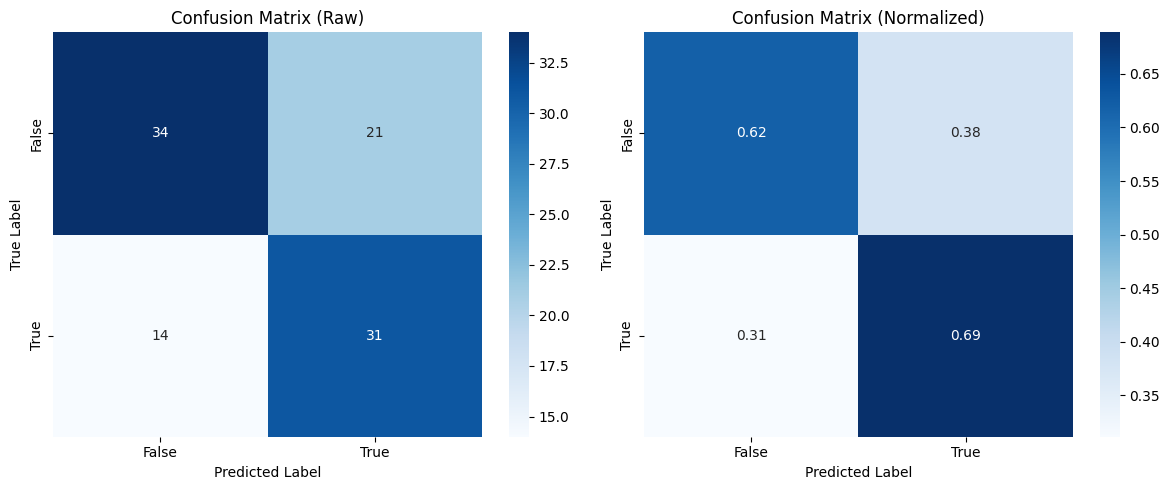

In [147]:
true_binary = [1 if label == 'true' else 0 for label in true_labels]
pred_binary = predicted_classes.tolist()

# Compute confusion matrix
cm = confusion_matrix(true_binary, pred_binary)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['False', 'True']

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Confusion Matrix (Raw)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [148]:
filtered_df = results_df[results_df['Correct'] == False]

In [149]:
filtered_df

,Statement,True Label,Predicted Probability,Predicted Class,Correct
1,"In a lawsuit between private citizens, a Flori...",true,0.4128,false,False
4,The United States spends $2.2 billion on free ...,false,0.5863,true,False
9,The U.S. doesnt make television sets anymore. ...,true,0.1612,false,False
10,"In February, John McCain suggested the Bergdah...",true,0.2421,false,False
12,The largest tax increase that we have ever had...,false,0.5765,true,False
17,Miami-Dade County is the No. 1 donor county in...,false,0.6329,true,False
19,Of the roughly 15 percent of Americans who don...,false,0.6231,true,False
22,Citizens Property Insurance has over $500 bill...,false,0.5743,true,False
24,Rick Perry attempted to fast-track unnecessary...,true,0.4066,false,False
37,"A mortgage buyback plan is ""my proposal, it's ...",true,0.4420,false,False
